In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [4]:
# Lifespan Day Index
day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


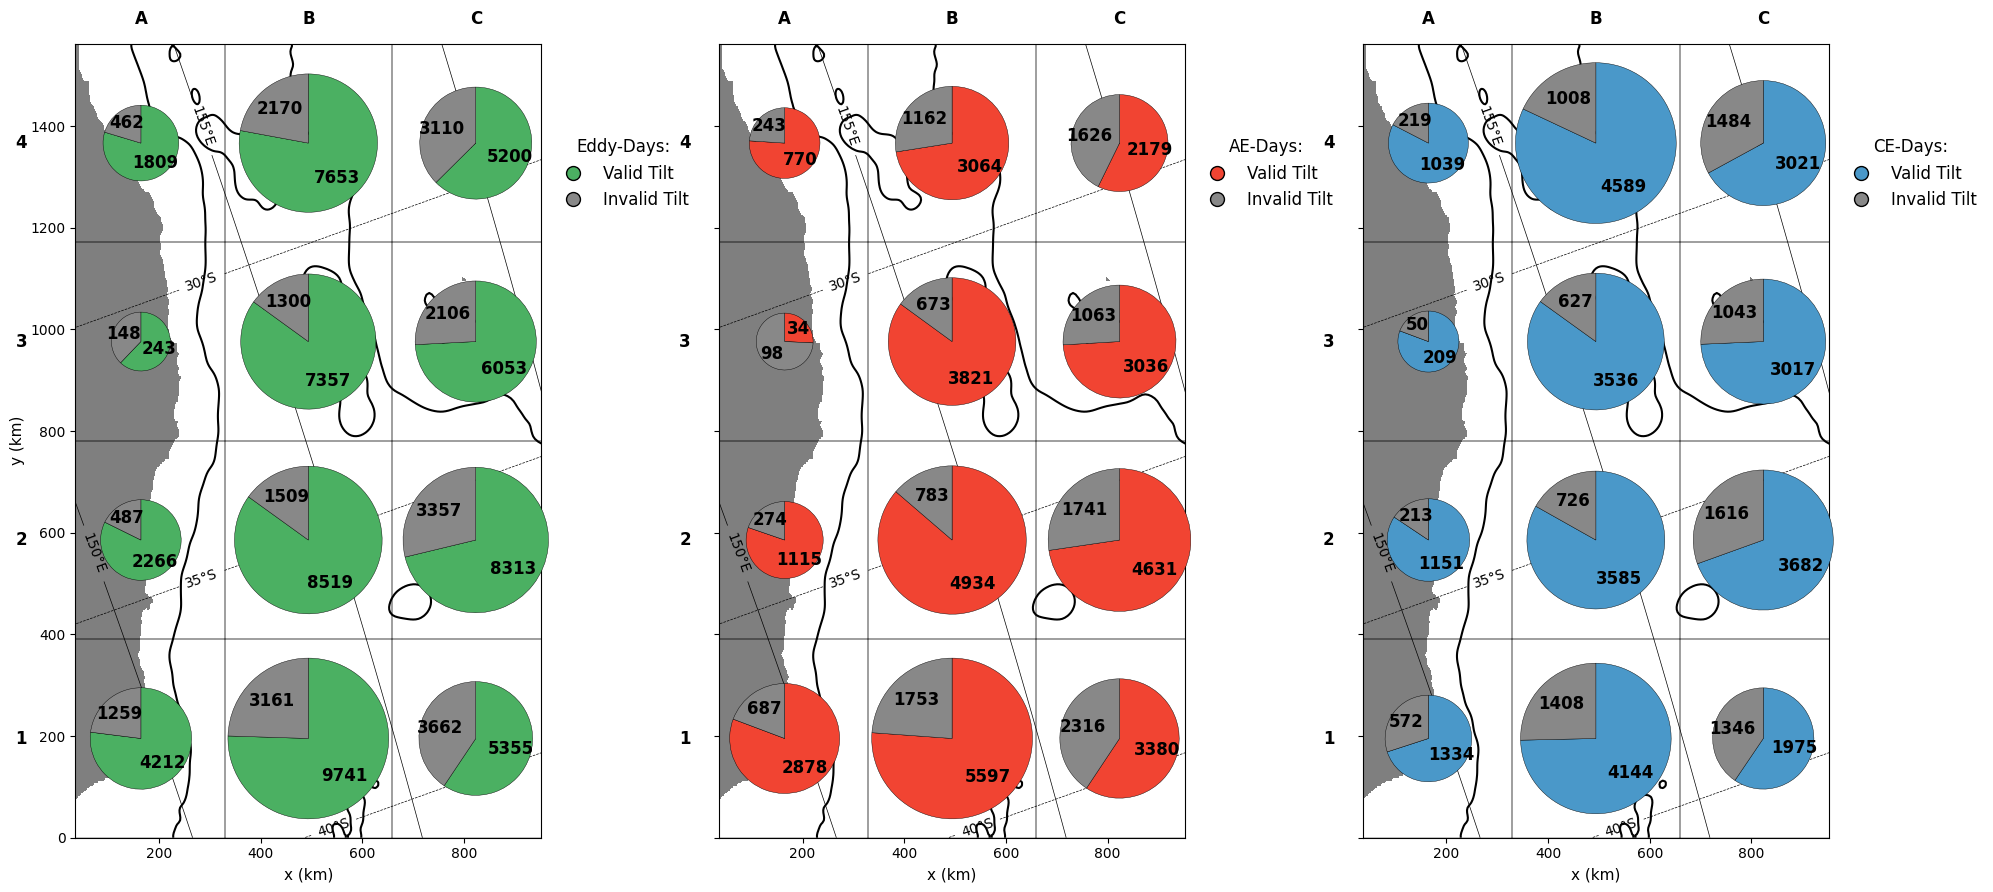

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


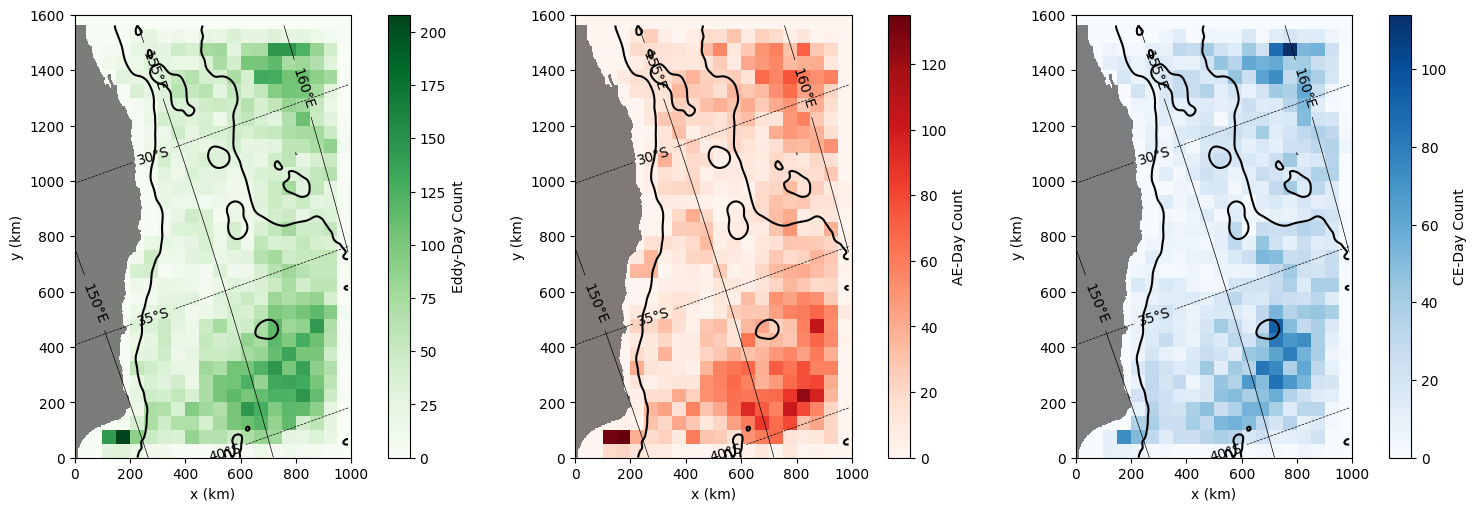

In [6]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [11]:
sum(~np.isnan(df_eddies.TiltDis))


66721